In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 2 - Coupled 3-box

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [41]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run scenarios
scenarios = ['2xCO2','High Emissions','Overshoot']
forcings, full_outputs, T_out = [], [], []
for i in range(n_boxes):
  forcings.append({})
  full_outputs.append({})
  T_out.append({})
  for j, scen in enumerate(scenarios):
    full_outputs[i][scen] = BudykoSellers.Run_Budyko_Sellers(scen_flag=j, n_boxes=n_boxes, diff_flag=1, spatial_flag=i+1)
    forcings[i][scen] = np.tile(full_outputs[i][scen]['forcing_ts'], (n_boxes, 1))
    T_out[i][scen] = np.squeeze(full_outputs[i][scen]['T_ts'])[0:n_boxes,:]

  for scen in scenarios:
    forcings[i][scen][1] = np.zeros(len(forcings[i][scen][1]))
    forcings[i][scen][2] = np.zeros(len(forcings[i][scen][2]))

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:324: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method X: DMD

In [52]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD, error_metrics_DMD = {}, {}, {}
scen = '2xCO2'
for forcing_box in range(n_boxes):
  operator_DMD[forcing_box], T_pred_DMD[forcing_box], error_metrics_DMD[forcing_box] = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out[forcing_box], forcings=forcings[forcing_box], w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)

  print(f'Forcing Box = {forcing_box}')
  for test_box in range(n_boxes):
    print(f'\tTest Box = {test_box}')
    T_pred_DMD = emulator_utils.estimate_w(forcings[test_box][scen], operator_DMD[forcing_box][scen], 'DMD', dt, w0, n_steps, n_boxes)
    print(emulator_utils.calc_error_metrics(T_pred_DMD, T_out[test_box][scen]))

    #emulator_utils.plot_true_pred(T_out[forcing_box], T_pred_DMD, scenarios)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [0.00821146 0.00854917 0.00946862]
	Test: High Emissions - [1.66083798 1.66332594 1.67803578]
	Test: Overshoot - [1.12479785 1.29533815 1.64419605]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.14455218 1.1784307  1.22642015]
	Test: High Emissions - [0.00059312 0.00070945 0.00095708]
	Test: Overshoot - [1.02025863 0.85240325 0.65263661]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [0.34210379 0.35844914 0.40534292]
	Test: High Emissions - [0.02814963 0.0311452  0.04116569]
	Test: Overshoot - [0.00187625 0.0022207  0.00295417]
Forcing Box = 0
	Test Box = 0
[0.0082121 0.0085499 0.0094695]
	Test Box = 1
[67.47663638 51.18386472 51.59153863]
	Test Box = 2
[ 59.18136563  52.15791051 190.93343766]
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [0.00821255 0.1270183  0.01050832]
	Test: High Emissions - [1.65908329 2.09207105 1.63810261]
	Test: Overshoot - [1.19274472 1.3502153  1.00486081]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.16021403 1.31705824

TypeError: float() argument must be a string or a real number, not 'dict'

### Method X: EDMD

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [0.00794683 0.06423648 0.01801414]
	Test: High Emissions - [1.65502953 1.87830153 1.65696023]
	Test: Overshoot - [1.11538565 1.17415027 1.06796178]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.13294138 1.18084258 1.05963111]
	Test: High Emissions - [0.00056159 0.00251121 0.00071712]
	Test: Overshoot - [1.04967891 1.87495536 1.67119453]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [0.35282279 3.59504377 0.87409741]
	Test: High Emissions - [0.02465823 0.13890648 0.03459778]
	Test: Overshoot - [0.00034296 0.00054205 0.00041805]


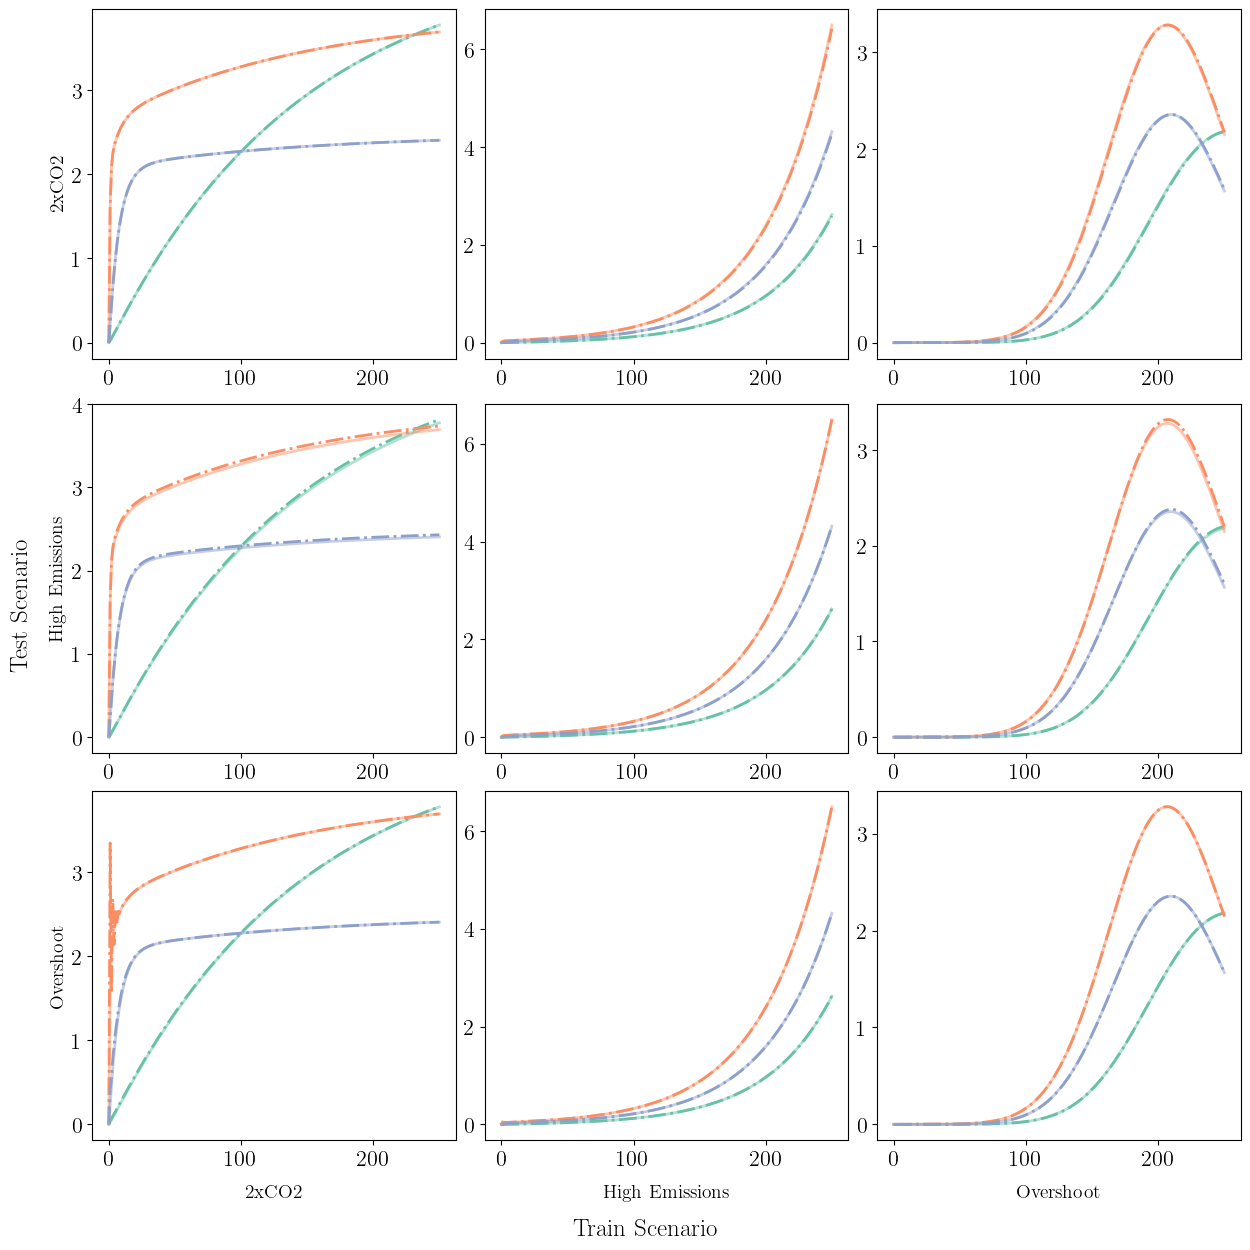

In [4]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
emulator_utils.plot_true_pred(T_out, T_pred_EDMD, scenarios)

### Method X: Deconvolution

In [53]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
#operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out, forcings=forcings, dt=dt)
#emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, scenarios)

n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = {}, {}, {}
scen = '2xCO2'
for forcing_box in range(n_boxes):
  operator_deconvolve[forcing_box], T_pred_deconvolve[forcing_box], error_metrics_deconvolve[forcing_box] = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out[forcing_box], forcings=forcings[forcing_box], w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)

  print(f'Forcing Box = {forcing_box}')
  for test_box in range(n_boxes):
    print(f'\tTest Box = {test_box}')
    T_pred_deconvolve = emulator_utils.estimate_w(forcings[test_box][scen], operator_deconvolve[forcing_box][scen], 'deconvolve', dt, w0, n_steps, n_boxes)
    print(emulator_utils.calc_error_metrics(T_pred_deconvolve, T_out[test_box][scen]))

    #emulator_utils.plot_true_pred(T_out[forcing_box], T_pred_DMD, scenarios)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [1.16531525e-13 3.93294913e-14 3.18741405e-14]
	Test: High Emissions - [1.62506734 1.6277353  1.64190526]
	Test: Overshoot - [1.10338806 1.27057118 1.61219388]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.12740769 1.16163678 1.20977342]
	Test: High Emissions - [1.01575692e-13 8.49776750e-14 1.08439217e-13]
	Test: Overshoot - [0.99683187 0.83250611 0.63687411]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [111710.74084399  55054.70116579  20751.82622184]
	Test: High Emissions - [8056.87682867 4772.21036954 3043.82167035]
	Test: Overshoot - [1.31997453e-13 9.96731741e-14 1.35829344e-13]
Forcing Box = 0
	Test Box = 0
[1.16531525e-13 3.93294913e-14 3.18741405e-14]
	Test Box = 1
[67.47774127 51.1766065  51.58286085]
	Test Box = 2
[ 59.18342476  52.14587483 190.90656078]
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [3.88971497e-14 1.38396211e-14 5.51306690e-15]
	Test: High Emissions - [1.62307713 2.01135647 1.60304519]
	Test: Overshoot - [1.16737557 1.2979

TypeError: float() argument must be a string or a real number, not 'dict'

### Method X: Direct Diagnosis (FDT)

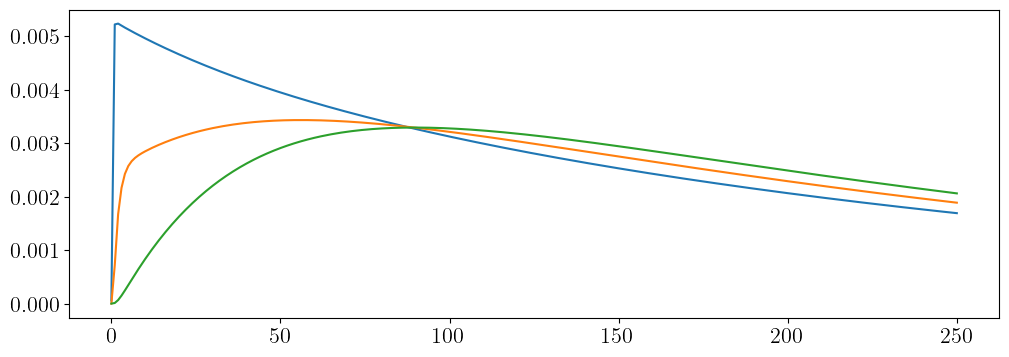

In [55]:
plt.plot(operator_direct.T)

Train: Impulse Forcing - L2 Error


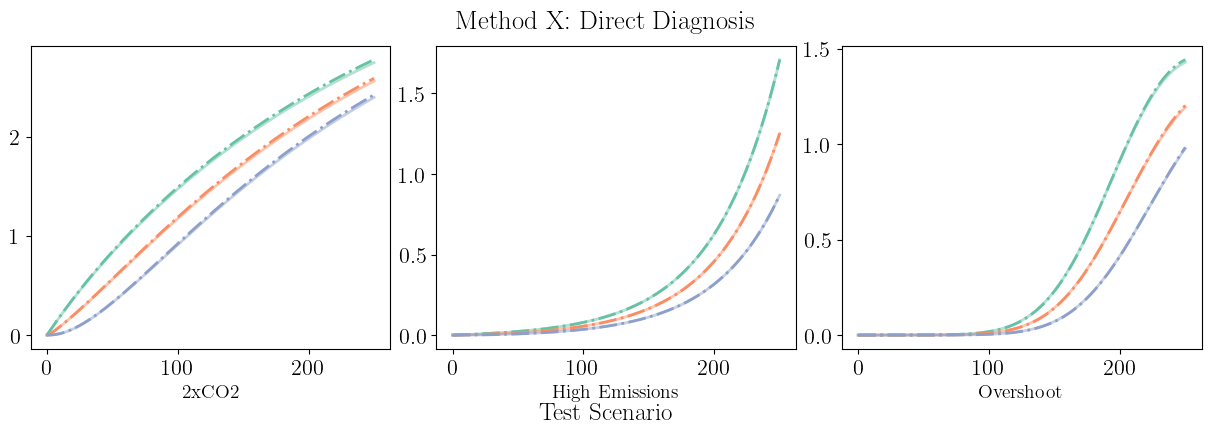

In [28]:
operator_direct, T_pred_direct, error_metrics_direct = emulator_utils.emulate_scenarios('direct', scenarios=scenarios, outputs=T_out, forcings=forcings, n_boxes=n_boxes, dt=dt, diff_flag=1, spatial_flag=1)
emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, scenarios)

### Method X: Exponential Fit

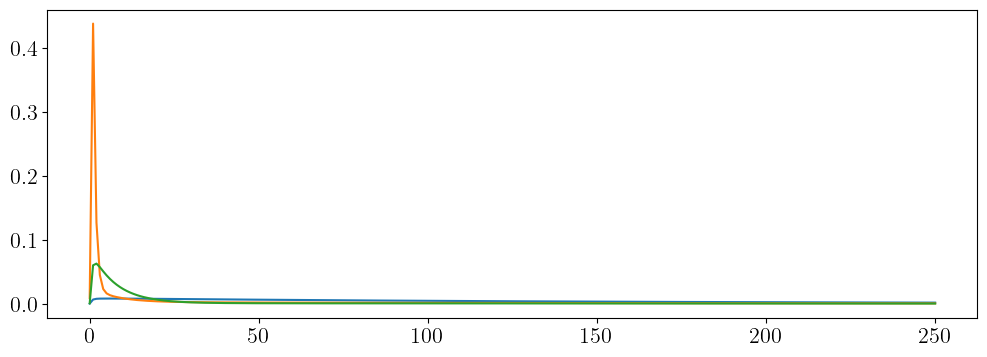

In [16]:
plt.plot(operator_direct.T)

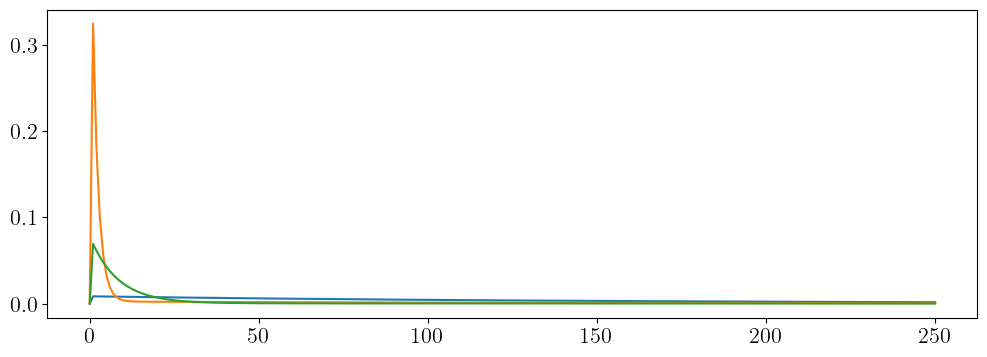

In [21]:
plt.plot(operator_fit['2xCO2'].T)

Train: 2xCO2 - L2 Error
[  4.774601   -13.72054    -12.554692    -6.0260205    0.5379371
 -10.653905    -7.961101   -12.623257     2.5517287   -5.006873
  -0.51783866  -2.0914643 ]
	Test: 2xCO2 - [0.28496813 1.63906248 1.66647469]
	Test: High Emissions - [0.23717574 0.10033448 0.98667712]
	Test: Overshoot - [0.45083118 1.17123624 2.36380623]
Train: High Emissions - L2 Error
[  5.0020075 -13.831814  -13.602336  -10.185218    1.2541285 -11.176974
 -11.174668  -13.199589    3.6788363  -6.7764163  -1.2313735  -3.5774767]
	Test: 2xCO2 - [29.38066665 10.32307578 35.4623965 ]
	Test: High Emissions - [0.89779322 1.40157068 0.59397812]
	Test: Overshoot - [ 7.88455151  5.51688181 40.70707306]
Train: Overshoot - L2 Error
[  4.8137136 -13.814913  -13.616618   -6.5684376   1.2060825 -11.36399
 -10.939208  -13.147879    2.6690567  -5.225664   -1.0919473  -2.208216 ]
	Test: 2xCO2 - [6.81843389 4.77853286 4.98936793]
	Test: High Emissions - [1.57368358 3.95375632 4.45344499]
	Test: Overshoot - [2.2986

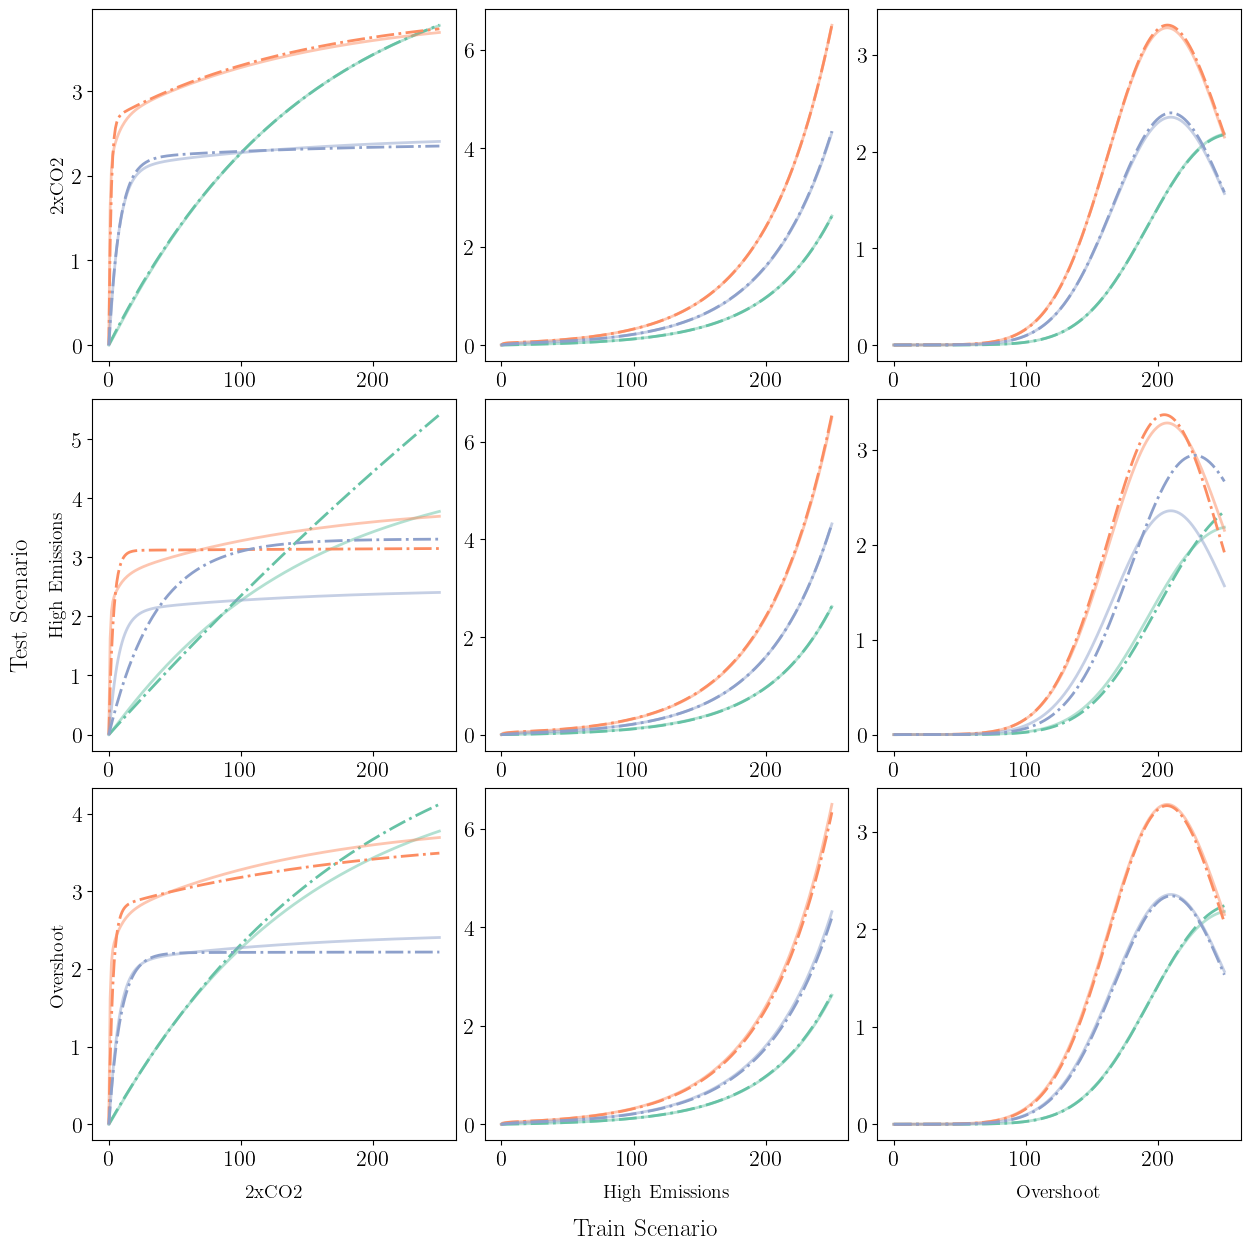

In [20]:
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_amp', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=3, B=np.ones(n_boxes))
emulator_utils.plot_true_pred(T_out, T_pred_fit, scenarios)

#### Method X: Pattern Scaling

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [24.03418973 10.15246331 12.04513309]
	Test: High Emissions - [100.99038222  25.1204414   22.6905553 ]
	Test: Overshoot - [69.83564237 19.0006429  21.52679674]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [47.69047436 21.30088399 20.53701619]
	Test: High Emissions - [1.24157756 0.3136215  0.33370431]
	Test: Overshoot - [50.11558507 17.98298878  9.66060862]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [36.75849775 14.21460985 19.40887475]
	Test: High Emissions - [32.82224961 11.77722356  1.95835787]
	Test: Overshoot - [42.41984529 13.83144362  9.49217531]


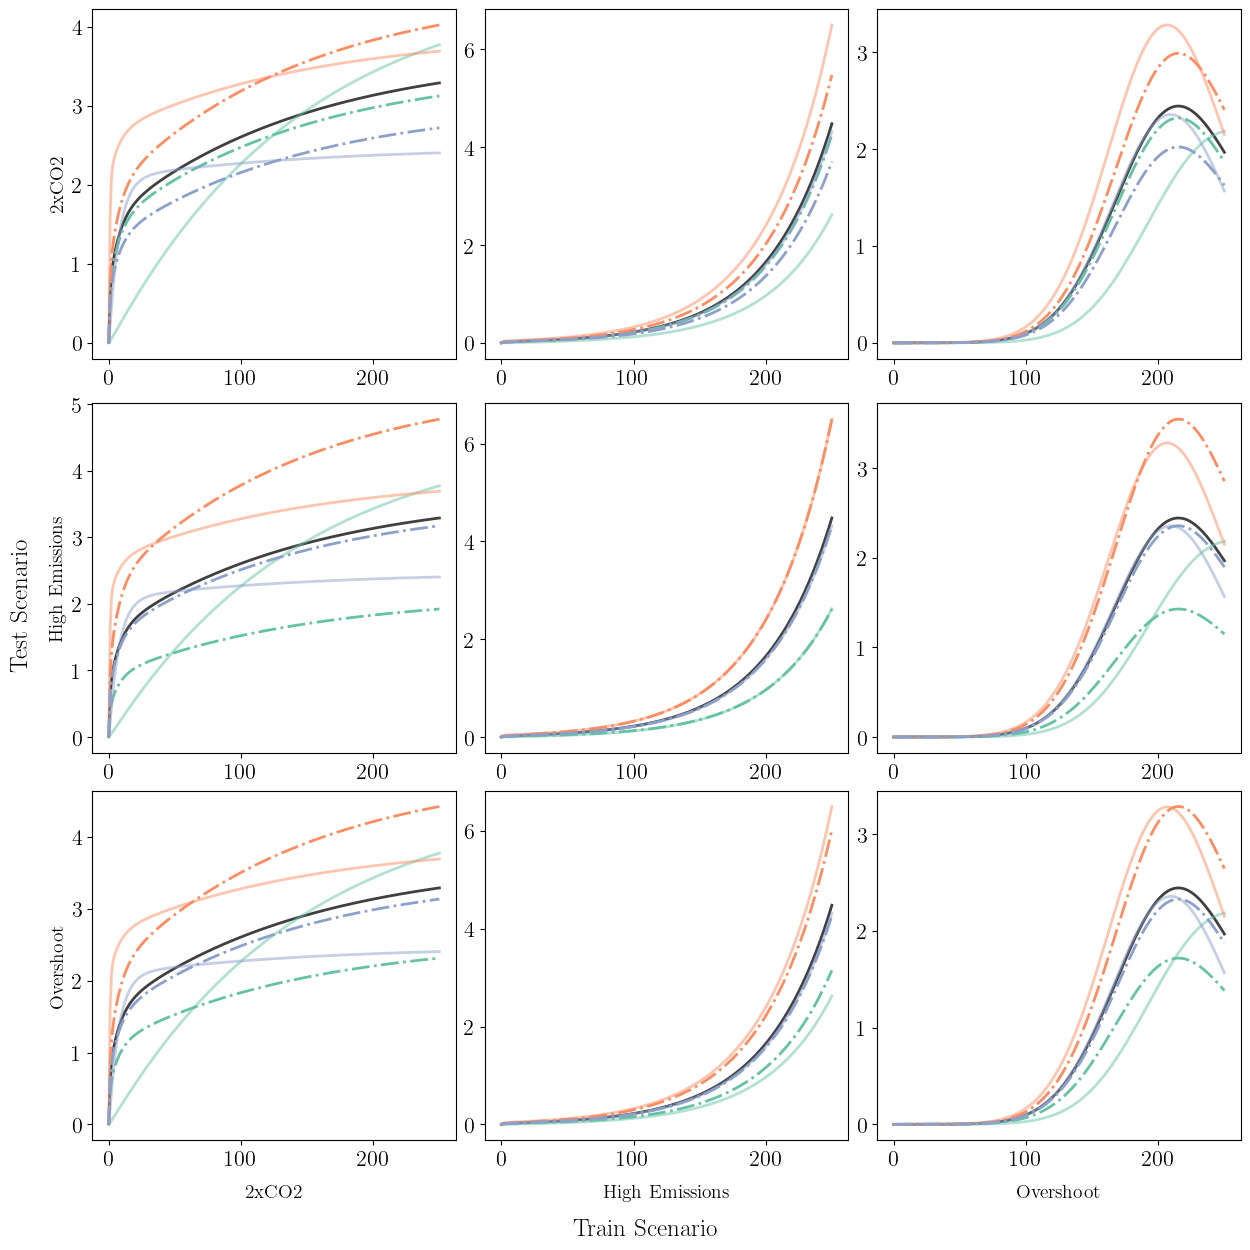

In [8]:
operator_PS, T_pred_PS, L2_PS = emulator_utils.emulate_scenarios('PS', scenarios=scenarios, outputs=T_out, forcings=forcings)
emulator_utils.plot_true_pred(T_out, T_pred_PS, scenarios, operator='PS')